In [2]:
import pydicom
import matplotlib.pyplot as plt

import os
import numpy as np
import vtk
from vtk.util.numpy_support import numpy_to_vtk

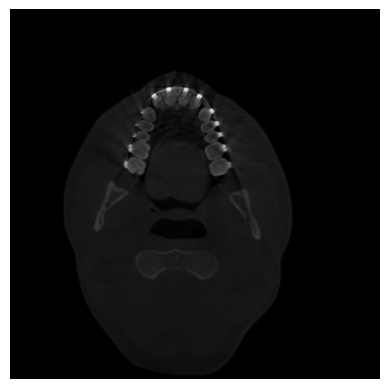

In [10]:
# Загрузка DICOM-файла
dcm_path = "files_dcm/0344.dcm"
dicom_data = pydicom.dcmread(dcm_path)

# Получение массива пикселей
image = dicom_data.pixel_array

# Отображение изображения
plt.imshow(image, cmap="gray")  # DICOM обычно в градациях серого
plt.axis("off")  # Отключаем оси для удобства
plt.show()


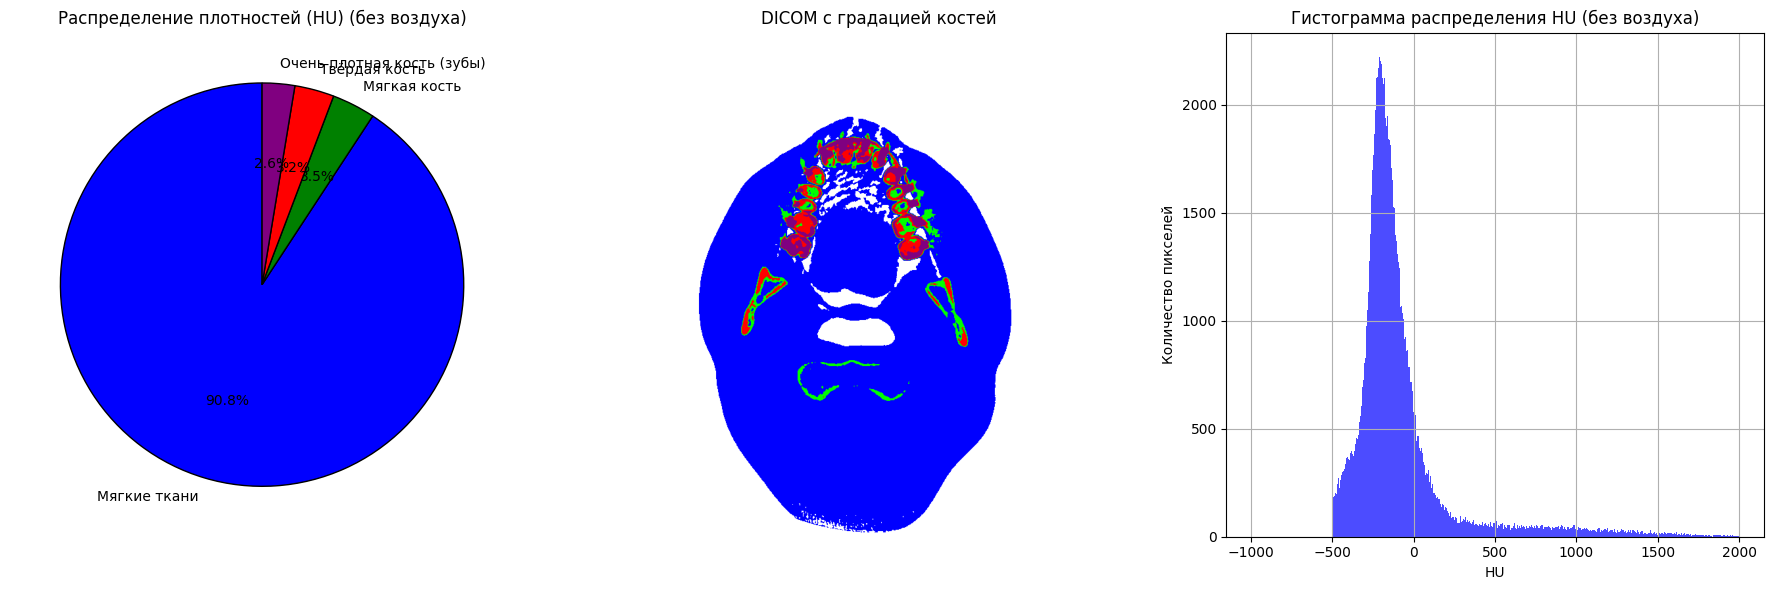

In [24]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt

# Загружаем DICOM-файл
dcm_path = "files_dcm/0344.dcm"
dicom_data = pydicom.dcmread(dcm_path)

# Получаем пиксельные данные
image = dicom_data.pixel_array.astype(np.int16)

# Корректируем HU
intercept = dicom_data.RescaleIntercept if "RescaleIntercept" in dicom_data else 0
slope = dicom_data.RescaleSlope if "RescaleSlope" in dicom_data else 1
hu_image = image * slope + intercept

# Определяем категории HU
air_mask = (hu_image <= -500)  # Воздух (не учитываем в гистограмме)
soft_tissue_mask = (hu_image > -500) & (hu_image < 300)  # Мягкие ткани
soft_bone_mask = (hu_image >= 300) & (hu_image < 700)  # Мягкая кость
hard_bone_mask = (hu_image >= 700) & (hu_image < 1200)  # Твёрдая кость
very_hard_bone_mask = (hu_image >= 1200)  # Очень плотная кость (зубы)

# Подсчитываем количество пикселей в каждой категории
counts = [
    np.sum(soft_tissue_mask), 
    np.sum(soft_bone_mask), 
    np.sum(hard_bone_mask), 
    np.sum(very_hard_bone_mask)
]

labels = ["Мягкие ткани", "Мягкая кость", "Твёрдая кость", "Очень плотная кость (зубы)"]
colors = ["blue", "green", "red", "purple"]

# Создаём цветное изображение
colored_image = np.zeros((*hu_image.shape, 3), dtype=np.uint8)
colored_image[air_mask] = [255, 255, 255]  # Фон
colored_image[soft_tissue_mask] = [0, 0, 255]  # Синий (мягкие ткани)
colored_image[soft_bone_mask] = [0, 255, 0]  # Зеленый (мягкая кость)
colored_image[hard_bone_mask] = [255, 0, 0]  # Красный (твёрдая кость)
colored_image[very_hard_bone_mask] = [128, 0, 128]  # Фиолетовый (очень плотная кость)

# Построение графиков
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Круговая диаграмма (без воздуха)
axes[0].pie(counts, labels=labels, autopct="%1.1f%%", colors=colors, startangle=90, wedgeprops={"edgecolor": "black"})
axes[0].set_title("Распределение плотностей (HU) (без воздуха)")

# Цветное DICOM-изображение
axes[1].imshow(colored_image)
axes[1].set_title("DICOM с градацией костей")
axes[1].axis("off")  # Отключаем оси

# Гистограмма HU (без воздуха)
hu_image_no_air = hu_image[~air_mask]  # Убираем воздух из массива данных
axes[2].hist(hu_image_no_air.flatten(), bins=1000, color="blue", alpha=0.7, range=(-1000, 2000))
axes[2].set_title("Гистограмма распределения HU (без воздуха)")
axes[2].set_xlabel("HU")
axes[2].set_ylabel("Количество пикселей")
axes[2].grid(True)

plt.tight_layout()
# fig.savefig("output_graphics.svg", format='svg')  # Сохранение как SVG
plt.show()

In [ ]:
dcm_dir = "files_dcm"

# Загружаем файлы
files = [pydicom.dcmread(os.path.join(dcm_dir, f)) for f in os.listdir(dcm_dir) if f.endswith(".dcm")]
files.sort(key=lambda x: int(x.InstanceNumber))

# Создаём 3D-массив
volume = np.stack([f.pixel_array for f in files])

# Преобразуем в VTK-объект
data = vtk.vtkImageData()
data.SetDimensions(volume.shape)
data.SetSpacing(1, 1, 1)
data.AllocateScalars(vtk.VTK_FLOAT, 1)
vtk_array = numpy_to_vtk(volume.ravel(), deep=True)
data.GetPointData().SetScalars(vtk_array)

# Создаём рендер
renderer = vtk.vtkRenderer()
actor = vtk.vtkVolume()
mapper = vtk.vtkSmartVolumeMapper()
mapper.SetInputData(data)
actor.SetMapper(mapper)
renderer.AddViewProp(actor)

# Окно
render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)

# Запуск
render_window.Render()
interactor.Start()